In [1]:
!git clone https://github.com/aldipiroli/pointnet.git

Cloning into 'pointnet'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 107 (delta 49), reused 76 (delta 25), pack-reused 0
Receiving objects: 100% (107/107), 12.61 MiB | 10.58 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [123]:
!git clone https://github.com/kelvis24/new-simple-point-clouds.git

Cloning into 'new-simple-point-clouds'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 10 (delta 0), reused 10 (delta 0), pack-reused 0
Receiving objects: 100% (10/10), 4.15 MiB | 19.21 MiB/s, done.


In [18]:
!pip install plyfile

In [2]:
import torch
from torch import nn
import torch.nn.functional as F


class mlp(nn.Module):
    def __init__(self, in_size, out_size, k_size=1, batchnorm=True):
        """
        Creates a mlp layer as described in the paper.

        in_size: input size of the mlp
        out_size: output size of the mlp
        relu: apply relu
        batchnorm: apply norm
        """
        super(mlp, self).__init__()
        self.batchnorm = batchnorm
        self.conv = nn.Conv1d(in_size, out_size, k_size)
        self.bn = nn.BatchNorm1d(out_size)

    def forward(self, x):
        if self.batchnorm:
            return F.relu(self.bn(self.conv(x)))
        else:
            return self.conv(x)


class fc(nn.Module):
    def __init__(self, in_size, out_size, k_size=1, batchnorm=True, dropout=False, dropout_p=0.7):
        """
        Creates a fully connected layer as described in the paper.

        in_size: input size of the mlp
        out_size: output size of the mlp
        relu: apply relu
        batchnorm: apply norm
        """
        super(fc, self).__init__()
        self.batchnorm = batchnorm
        self.dropout = dropout

        self.fc = nn.Linear(in_size, out_size)
        self.bn = nn.BatchNorm1d(out_size)
        self.dp = nn.Dropout(p=dropout_p)

    def forward(self, x):
        if self.batchnorm and not self.dropout:
            return F.relu(self.bn(self.fc(x)))
        elif self.batchnorm and self.dropout:
            return F.relu(self.bn(self.dp(self.fc(x))))
        elif not self.batchnorm:
            return self.fc(x)


class TNet3(nn.Module):
    def __init__(self, device):
        super(TNet3, self).__init__()

        self.device = device

        self.mlp1 = mlp(3, 64)
        self.mlp2 = mlp(64, 128)
        self.mlp3 = mlp(128, 1024)

        self.fc1 = fc(1024, 512)
        self.fc2 = fc(512, 256, dropout=True)
        self.fc3 = fc(256, 9)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.mlp1(x)
        x = self.mlp2(x)
        x = self.mlp3(x)

        x = torch.max(x, 2)[0]

        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        #  For stability
        iden = torch.eye(3, 3).repeat(batch_size, 1, 1)
        if x.is_cuda:
            iden = iden.to(self.device)

        x = x.view(-1, 3, 3)
        x = x + iden

        return x


class TNet64(nn.Module):
    def __init__(self, device):
        super(TNet64, self).__init__()

        self.device = device

        self.mlp1 = mlp(64, 64)
        self.mlp2 = mlp(64, 128)
        self.mlp3 = mlp(128, 1024)

        self.fc1 = fc(1024, 512)
        self.fc2 = fc(512, 256, dropout=True)
        self.fc3 = fc(256, 64 * 64)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.mlp1(x)
        x = self.mlp2(x)
        x = self.mlp3(x)

        x = torch.max(x, 2)[0]

        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        #  For stability
        iden = torch.eye(64, 64).repeat(batch_size, 1, 1)
        if x.is_cuda:
            iden = iden.to(self.device)

        x = x.view(-1, 64, 64)
        x = x + iden

        return x


class PointNetClass(nn.Module):
    def __init__(self, device, classes=10):
        """
        k: number of classes which a the input (shape) can be classified into
        """
        super(PointNetClass, self).__init__()
        self.device = device
        self.classes = classes

        self.TNet3 = TNet3(self.device)
        self.TNet64 = TNet64(self.device)

        self.mlp1 = mlp(3, 64)
        self.mlp2 = mlp(64, 64)
        self.mlp3 = mlp(64, 128)
        self.mlp4 = mlp(128, 1024)

        self.mlp5 = mlp(1024, 512)
        self.mlp6 = mlp(512, 256)
        self.mlp7 = mlp(256, self.classes, batchnorm=False)

    def forward(self, x):
        #  input transform:
        x_ = x.clone()
        T3 = self.TNet3(x_)
        x = torch.matmul(T3, x)

        #  mlp (64,64):
        x = self.mlp1(x)
        x = self.mlp2(x)

        # feature transform:
        x_ = x.clone()
        T64 = self.TNet64(x_)
        x = torch.matmul(T64, x)

        #  mlp (64,128,1024):
        x = self.mlp3(x)
        x = self.mlp4(x)

        x = torch.max(x, 2, keepdim=True)[0]

        x = self.mlp5(x)
        x = self.mlp6(x)
        x = self.mlp7(x)

        return x.squeeze(), T64


class PointNetSeg(nn.Module):
    def __init__(self, device, m=50):
        """
        m: number of classes which a single point can be classified into
        """
        super(PointNetSeg, self).__init__()
        self.device = device
        self.m = m

        self.TNet3 = TNet3(self.device)
        self.TNet64 = TNet64(self.device)

        self.mlp1 = mlp(3, 64)
        self.mlp2 = mlp(64, 64)
        self.mlp3 = mlp(64, 64)
        self.mlp4 = mlp(64, 128)
        self.mlp5 = mlp(128, 1024)

        self.mlp6 = mlp(1088, 512)
        self.mlp7 = mlp(512, 256)
        self.mlp8 = mlp(256, 128)
        self.mlp9 = mlp(128, self.m, batchnorm=False)


    def forward(self, x):
        #  input transform:
        x_ = x.clone()
        T3 = self.TNet3(x_)
        x = torch.matmul(T3, x)

        #  mlp (64,64):
        x = self.mlp1(x)
        x = self.mlp2(x)

        # feature transform:
        x_ = x.clone()
        T64 = self.TNet64(x_)

        x = torch.matmul(T64, x)

        x_feature = x.clone()

        #  mlp (64,128,1024):
        x = self.mlp3(x)
        x = self.mlp4(x)
        x = self.mlp5(x)

        x_globfeat = torch.max(x, 2, keepdim=True)[0]

        #  Concatenate global and local features
        x_globfeat = x_globfeat.expand(-1, -1, x_feature.shape[2])
        x = torch.cat((x_feature, x_globfeat), dim=1)

        x = self.mlp6(x)
        x = self.mlp7(x)
        x = self.mlp8(x)
        x = self.mlp9(x)

        return x, T64


if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    input = torch.rand((10, 3, 500))
    net = TNet3(device)
    y = net(input)
    print("T-Net 3", y.shape)

    input = torch.rand((10, 64, 500))
    net = TNet64(device)
    y = net(input)
    print("T-Net 64", y.shape)

    # input = torch.rand((10, 3, 500))
    # net = PointNetClass(device, 15)
    # y = net(input)
    # print("PointNet Class", y.shape)

    input = torch.rand((10, 3, 500))
    net = PointNetClass(device, 15)
    y, _ = net(input)  # unpack the tuple
    print("PointNet Class", y.shape)

    input = torch.rand((10, 3, 500))
    net = PointNetSeg(device, 50)
    x, _ = net(input)
    print("PointNet Segm", x.shape)


T-Net 3 torch.Size([10, 3, 3])
T-Net 64 torch.Size([10, 64, 64])
PointNet Class torch.Size([10, 15])
PointNet Segm torch.Size([10, 50, 500])


Loss

In [3]:
import torch
from torch import nn


class PointNetLoss(nn.Module):
    def __init__(self, device, w=0.0001):
        super(PointNetLoss, self).__init__()
        self.w = w
        self.nll_loss = nn.CrossEntropyLoss()
        self.device = device

    def forward(self, gt, pr, A_):
        A = A_.clone()
        #  Orthogonality constraint
        orth = torch.norm(torch.eye(A.shape[1]).to(self.device) - torch.matmul(A, A.transpose(1, 2)))
        loss = self.nll_loss(pr, gt) + self.w * orth
        return loss


if __name__ == "__main__":
    batch_size = 5
    classes = 15

    pred = torch.randn(batch_size, classes, requires_grad=True)
    target = torch.empty(batch_size, dtype=torch.long).random_(classes)
    A = torch.rand(batch_size, 64, 64)

    print("pred.shape: ",pred.shape, "target.shape: ",target.shape, "A.shape", A.shape)
    # pred.shape:  torch.Size([5, 15])
    # target.shape:  torch.Size([5])
    # A.shape torch.Size([5, 64, 64])


    # loss = PointNetLoss()
    # output = loss(target, pred, A)

    loss = PointNetLoss(device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    output = loss(target, pred, A)

    print(output)


pred.shape:  torch.Size([5, 15]) target.shape:  torch.Size([5]) A.shape torch.Size([5, 64, 64])
tensor(3.7078, grad_fn=<AddBackward0>)


In [67]:
import os
from os import walk
import numpy as np
import pickle

SHAPE_NPARTS = {
    "02691156": 4,
    "02773838": 2,
    "02954340": 2,
    "02958343": 4,
    "03001627": 4,
    "03261776": 3,
    "03467517": 3,
    "03624134": 2,
    "03636649": 4,
    "03642806": 2,
    "03790512": 6,
    "03797390": 2,
    "03948459": 3,
    "04099429": 3,
    "04225987": 3,
    "04379243": 3,
}

def map_shape_label(path):
    list_dir_nparts = []
    dir_list = next(os.walk(path))[1]
    for i, dir_name in enumerate(dir_list):
        print("Processing ", i, " out of", len(dir_list))
        dir_nparts = {}

        if "0" in dir_name:
            path_label_folder = os.path.join(path, dir_name, "points_label")
            filenames = next(walk(path_label_folder), (None, None, []))[2]  # [] if no file
            max_val = -1
            for file_name in filenames:
                path_label_file = os.path.join(path_label_folder, file_name)
                labels = np.loadtxt(path_label_file, delimiter=" ", dtype=np.int32)
                max_label = np.max(labels)
                if max_label > max_val:
                    max_val = max_label

            dir_nparts[dir_name] = max_val
            list_dir_nparts.append(dir_nparts)
            print(dir_name, max_val)


    with open('map_folder_list', 'wb') as fp:
        pickle.dump(list_dir_nparts, fp)

    print("Finished saving map")

def read_map(path):
    print(path)
    with open (path, 'rb') as fp:
        itemlist = pickle.load(fp)
        print(itemlist)
    dic_ = {}
    for item in itemlist:
        for key, val in item.items():
            dic_[key] = val
    dic = {}
    for key in sorted(dic_):
        dic[key] = dic_[key]

    print("***"*20)
    print(dic)

def find_offsets():
    dic_off = {}
    i = 0
    sum_idx = 0
    for i, (key, val) in enumerate(SHAPE_NPARTS.items()):
        dic_off[key] = sum_idx
        sum_idx += val
    print(dic_off)
if __name__ == "__main__":
    # map_shape_label("/Users/aldi/workspace/pointnet/data/shape_data")
    # read_map("/Users/aldi/workspace/pointnet/src/utils/map_folder_list.pkl")
    find_offsets()

{'02691156': 0, '02773838': 4, '02954340': 6, '02958343': 8, '03001627': 12, '03261776': 16, '03467517': 19, '03624134': 22, '03636649': 24, '03642806': 28, '03790512': 30, '03797390': 36, '03948459': 38, '04099429': 41, '04225987': 44, '04379243': 47}


In [69]:
from torch.utils.data import Dataset, DataLoader
import os
import re
import json
import torch
import numpy as np
import random
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

SHAPE_NPARTS = {
    "02691156": 4,
    "02773838": 2,
    "02954340": 2,
    "02958343": 4,
    "03001627": 4,
    "03261776": 3,
    "03467517": 3,
    "03624134": 2,
    "03636649": 4,
    "03642806": 2,
    "03790512": 6,
    "03797390": 2,
    "03948459": 3,
    "04099429": 3,
    "04225987": 3,
    "04379243": 3,
}

LABEL_OFFSETS = {
    "02691156": 0,
    "02773838": 4,
    "02954340": 6,
    "02958343": 8,
    "03001627": 12,
    "03261776": 16,
    "03467517": 19,
    "03624134": 22,
    "03636649": 24,
    "03642806": 28,
    "03790512": 30,
    "03797390": 36,
    "03948459": 38,
    "04099429": 41,
    "04225987": 44,
    "04379243": 47,
}

LABEL_IDX = {
    "Airplane": 0,
    "Bag": 1,
    "Cap": 2,
    "Car": 3,
    "Chair": 4,
    "Earphone": 5,
    "Guitar": 6,
    "Knife": 7,
    "Lamp": 8,
    "Laptop": 9,
    "Motorbike": 10,
    "Mug": 11,
    "Pistol": 12,
    "Rocket": 13,
    "Skateboard": 14,
    "Table": 15,
}


class ShapeNetDataset(Dataset):
    def __init__(self, data_path, N=1024, split=1, augment=False):
        """
        N: number of points to sample out of the total shape
        split 0: test
        split 1: train
        split 2: val
        """
        self.data_path = data_path
        assert os.path.isdir(self.data_path), ("Data Path is Not Corret: ", self.data_path)
        self.N = N
        self.augment = augment
        self.split = split

        self.class_map = self.load_class_map()
        self.file_list = self.load_files(self.split)

    def load_files(self, split):
        """
        split 0: test
        split 1: train
        split 2: val
        """

        split_name = [
            "shuffled_test_file_list.json",
            "shuffled_train_file_list.json",
            "shuffled_val_file_list.json",
        ]

        path = os.path.join(self.data_path, "shape_data", "train_test_split", split_name[split])
        assert os.path.isfile(path), ("Path does not exist", path)

        datas = []
        with open(path) as json_file:
            data_list = json.load(json_file)
            for data in data_list:
                d = re.split(r"/+", data)

                data = {}
                points_ = os.path.join(self.data_path, d[0], d[1], "points", d[2] + ".pts")
                label_ = os.path.join(self.data_path, d[0], d[1], "points_label", d[2] + ".seg")

                # Check if shape has enough points:
                assert os.path.isfile(points_), ("Points file does not exist: ", points_)
                assert os.path.isfile(label_), ("Label file does not exist: ", label_)
                data["points"] = points_
                data["label"] = label_
                data["class"] = self.class_map[d[1]]
                data["folder"] = d[1]

                datas.append(data)

        return datas

    def load_class_map(self):
        """
        Create a map label -> folder_name
        """
        path = os.path.join(self.data_path, "shape_data/synsetoffset2category.txt")
        assert os.path.isfile(path), ("The file does not exist: ", path)

        f = open(path, "r")
        content = f.read()
        content_list = content.splitlines()
        f.close()

        class_map = {}
        for content in content_list:
            label, folder = re.split(r"\t+", content)
            class_map[folder] = label

        return class_map

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        data = self.file_list[idx]
        points = np.loadtxt(data["points"], delimiter=" ", dtype=np.float32)
        labels = np.loadtxt(data["label"], delimiter=" ", dtype=np.int32)
        class_name = data["class"]


        #  Sample subset of points:
        if points.shape[0] >= self.N:
            samples = random.sample(range(points.shape[0]), self.N)
            points = points[samples]
            labels = labels[samples]

        #  Correct the label offset:
        folder = data["folder"]
        offset = LABEL_OFFSETS[folder]
        labels = (labels - 1) + offset

        #  Correct the original rotation:
        points = correct_rotation(points)

        # Augment point cloud (rotation + noise)
        if self.augment:
            points = apply_augmentation(points)

        # Correct points shape and type
        points = points.transpose(1,0)
        points = torch.from_numpy(points)
        labels = torch.from_numpy(labels)
        labels = labels.type(torch.LongTensor)

        class_id = np.array(LABEL_IDX[class_name])
        class_id = torch.from_numpy(class_id)

        # Hack, should find a way to skip it during the return
        if points.shape[1] < self.N:
            points = torch.rand((3, self.N))
            labels = torch.rand((self.N))
            labels = labels.type(torch.LongTensor)

        return points, labels, class_id


def correct_rotation(points):
    th = -np.pi / 2
    c = np.cos(th)
    s = np.sin(th)
    Rx = np.array(([1, 0, 0], [0, c, -s], [0, s, c]))

    return np.matmul(points, Rx)


def apply_augmentation(points):
    # Get random rotation matrix around z:
    th = random.uniform(0, 1) * 2 * np.pi
    c = np.cos(th)
    s = np.sin(th)
    Rz = np.array(([c, -s, 0], [s, c, 0], [0, 0, 1]))

    points = np.matmul(points, Rz)

    # Change position of the points:
    noise = np.random.uniform(0, 0.2, size=points.shape)
    points += noise

    points =points.astype(np.float32)
    return points


def visualize_shape(points):
    fig = pyplot.figure()
    ax = Axes3D(fig)

    ax.scatter(points[:, 0], points[:, 1], points[:, 2])
    pyplot.xlabel("X axis label")
    pyplot.ylabel("Y axis label")
    pyplot.show()



In [72]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.optim as optim
import os

import numpy as np

class Trainer:
    def __init__(self):
        DATASET_PATH = "/content/drive/MyDrive/data/"
        DATASET_PATH = "data/"

        # Training Parameters:
        self.batch_size = 10
        self.lr = 0.001
        self.n_epochs = 1000
        self.model_path = "model/model_class.pth"
        self.load_model= True

        # Use GPU?
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Training on Device: ", self.device)

        # ===== Dataloader =====:
        self.dataset = ShapeNetDataset(DATASET_PATH, augment=True, split=1)
        self.dataloader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=False)

        self.dataset_val = ShapeNetDataset(DATASET_PATH, augment=True, split=2)
        self.dataloader_val = DataLoader(self.dataset_val, batch_size=self.batch_size, shuffle=False)

        #  Network:
        self.net = PointNetClass(self.device, classes=16).to(self.device)

        # Optimizer:
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)

        # Loss:
        self.loss = PointNetLoss(self.device)

        # Load Model?
        if self.load_model and os.path.isfile(self.model_path):
            self.net = torch.load(self.model_path)
            print("Loaded Path: ", self.model_path)

    def train(self):
        print("Training Classification PointNet!")
        for epoch in range(self.n_epochs):
            #  Training Loop:
            self.net.train()
            for i, (points, _, target) in enumerate(self.dataloader):
                points = points.to(self.device)
                target = target.to(self.device)


                # Compute Network Output
                pred, A = self.net(points)
                # Compute Loss
                loss = self.loss(target, pred, A)

                # Optimize:
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                if i % 25 == 0:
                    print("="*50)
                    print("Epoch: %d, i: %d, Error Loss: %f" % (epoch, i, loss))
                    pred_ = torch.max(pred,1)[1]
                    print("Pred: ", pred_)
                    print("Targ: ", target)

            # Save the model:
            torch.save(self.net.state_dict(), self.model_path)

            # Validate:
            self.net.eval()
            val_loss = 0
            for i, (points, _, target) in enumerate(self.dataloader_val):
                points = points.to(self.device)
                target = target.to(self.device)

                pred, A = self.net(points)
                loss = self.loss(target, pred, A)
                val_loss += loss
                if i % 25 == 0:
                    print("Epoch: %d, i: %d, Validation Loss: %f" % (epoch, i, val_loss))



In [75]:
import numpy as np
import torch
from torch.utils.data import Dataset

class SyntheticDataset(Dataset):
    def __init__(self, num_samples, num_points, num_classes):
        self.num_samples = num_samples
        self.num_points = num_points
        self.num_classes = num_classes

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Generate random point cloud
        points = np.random.rand(self.num_points, 3)  # Random (x, y, z) coordinates
        labels = np.random.randint(0, self.num_classes, self.num_points)  # Random labels

        # Convert to PyTorch tensors
        points = torch.tensor(points, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.long)

        return points, labels

# Example usage:
synthetic_dataset = SyntheticDataset(num_samples=1000, num_points=500, num_classes=15)
points, labels = synthetic_dataset[0]
print("Sample Point Cloud:", points)
print("Sample Labels:", labels)


Sample Point Cloud: tensor([[0.8537, 0.1763, 0.4943],
        [0.9881, 0.9149, 0.9097],
        [0.1959, 0.5934, 0.2379],
        ...,
        [0.8005, 0.4190, 0.2374],
        [0.9893, 0.7704, 0.4281],
        [0.3460, 0.2250, 0.3463]])
Sample Labels: tensor([ 1,  1,  0, 10, 11,  7, 12,  7,  4,  5,  0, 11,  1,  0,  4, 12,  0,  5,
        11,  6, 10,  7,  2, 11, 13, 12,  0,  9, 13,  2,  2, 11,  3,  3,  6,  1,
         3,  8,  5, 14, 10,  5, 10,  3,  1,  8,  0, 10, 10, 10,  7, 13,  8, 12,
        12, 10, 13,  1,  4, 11,  7,  1, 10,  0,  0, 14,  4,  3,  3, 11, 10,  2,
         6, 11,  5,  2,  9, 12,  6,  4,  5,  9,  8,  1,  6, 10,  6, 13, 13,  2,
        13,  6,  0,  8, 14, 11,  4,  1,  6,  1,  2,  7,  6,  8, 10,  9,  8,  6,
        13,  4,  1, 13, 12, 14, 11, 13,  8,  2,  1, 12,  5,  8,  6,  6, 14, 11,
         9, 13, 14,  4,  8,  5,  2,  3, 12,  0, 13,  9, 12,  0,  2, 14,  3,  0,
         8, 10,  8,  5,  9,  9, 11,  3,  4,  0,  4,  3, 12,  9,  9, 14,  2,  3,
         9,  5, 13,  8,  9,

In [77]:
import os
import numpy as np

# Create a new directory for the synthetic data
new_directory = "/content/synthetic_data"
os.makedirs(new_directory, exist_ok=True)

# Generate synthetic data
num_samples = 100
num_points = 1000
num_classes = 15

for i in range(num_samples):
    # Generate random points
    points = np.random.rand(num_points, 3)
    # Generate random labels
    labels = np.random.randint(num_classes, size=num_points)

    # Save the data to files
    np.save(os.path.join(new_directory, f"points_{i}.npy"), points)
    np.save(os.path.join(new_directory, f"labels_{i}.npy"), labels)

print("Synthetic data generation complete.")


Synthetic data generation complete.


In [79]:
import os

class ShapeNetDataset:
    def __init__(self, data_path, N=1024, split='train', augment=False):
        self.data_path = data_path
        assert os.path.isdir(self.data_path), ("Data Path is Not Correct: ", self.data_path)
        self.N = N
        self.split = split
        self.augment = augment

        # Load class mapping
        self.class_map = self.load_class_map()

    def load_class_map(self):
        """
        Load class mapping from synsetoffset2category.txt
        """
        class_map = {}
        path = os.path.join(self.data_path, "shape_data/synsetoffset2category.txt")
        if not os.path.isfile(path):
            print("Warning: synsetoffset2category.txt not found. Class mapping will be empty.")
            return class_map

        with open(path, "r") as f:
            for line in f:
                line = line.strip().split()
                class_map[line[1]] = line[0]
        return class_map


In [81]:
import os

class ShapeNetDataset:
    def __init__(self, data_path, augment=False):
        self.data_path = data_path
        self.augment = augment
        # Load class mapping
        self.class_map = self.load_class_map()

    def load_class_map(self):
        class_map = {}
        path = os.path.join(self.data_path, "shape_data/synsetoffset2category.txt")
        if os.path.isfile(path):
            with open(path, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    class_map[parts[1]] = parts[0]
        else:
            print("Warning: synsetoffset2category.txt not found. Class mapping will be empty.")
        return class_map

    def __getitem__(self, index):
        # Placeholder implementation to retrieve data at the specified index
        points = [[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 0.9]]  # Example points data
        labels = [0, 1, 2]  # Example labels data
        name = "example_name"  # Example name data
        return points, labels, name

    def __len__(self):
        # Placeholder implementation to return the total number of data samples
        return 100  # Example total number of samples

if __name__ == "__main__":
    data = ShapeNetDataset("/content/synthetic_data", augment=False)
    points, labels, name = data[34]
    print("points:", points)
    print("labels:", labels)
    print("name:", name)


points: [[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 0.9]]
labels: [0, 1, 2]
name: example_name


In [82]:
if __name__ == "__main__":
    data = ShapeNetDataset("/content/synthetic_data", augment=False)
    points, labels, name = data[34]
    print("points:", points)
    print("labels:", labels)
    print("name:", name)


points: [[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 0.9]]
labels: [0, 1, 2]
name: example_name


In [88]:
import os
import torch

class ShapeNetDataset:
    def __init__(self, data_path, augment=False):
        self.data_path = data_path
        self.augment = augment
        # Load class mapping
        self.class_map = self.load_class_map()

    def load_class_map(self):
        class_map = {}
        path = os.path.join(self.data_path, "shape_data/synsetoffset2category.txt")
        if os.path.isfile(path):
            with open(path, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    class_map[parts[1]] = parts[0]
        else:
            print("Warning: synsetoffset2category.txt not found. Class mapping will be empty.")
        return class_map

    def __getitem__(self, index):
        # Placeholder implementation to retrieve data at the specified index
        points = torch.tensor([[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 0.9]])  # Convert to tensor
        labels = torch.tensor([0, 1, 2])  # Convert to tensor
        name = "example_name"  # Example name data
        return points, labels, name

    def __len__(self):
        # Placeholder implementation to return the total number of data samples
        return 100  # Example total number of samples

if __name__ == "__main__":
    data = ShapeNetDataset("/content/synthetic_data", augment=False)
    points, labels, name = data[34]
    print("points:", points)
    print("labels:", labels)
    print("name:", name)


points: tensor([[0.1000, 0.2000, 0.3000],
        [0.4000, 0.5000, 0.6000],
        [0.7000, 0.8000, 0.9000]])
labels: tensor([0, 1, 2])
name: example_name


In [ ]:
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
import os

class Trainer:
    def __init__(self):
        DATASET_PATH = "/content/drive/MyDrive/data/"
        DATASET_PATH = "data/"

        # Training Parameters:
        self.batch_size = 10
        self.lr = 0.001
        self.n_epochs = 1000
        self.model_path = "model/model_class.pth"
        self.load_model= True

        # Use GPU?
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Training on Device: ", self.device)

        # Dataloader:
        self.dataset = ShapeNetDataset(DATASET_PATH, augment=True)
        self.dataloader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=False)

        self.dataset_val = ShapeNetDataset(DATASET_PATH, augment=True)
        self.dataloader_val = DataLoader(self.dataset_val, batch_size=self.batch_size, shuffle=False)

        # Network:
        self.net = PointNetClass(self.device, classes=16).to(self.device)

        # Optimizer:
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)

        # Loss:
        self.loss = PointNetLoss(self.device)

        # Load Model?
        if self.load_model and os.path.isfile(self.model_path):
            self.net.load_state_dict(torch.load(self.model_path))
            print("Loaded Path: ", self.model_path)

    def train(self):
        print("Training Classification PointNet!")
        for epoch in range(self.n_epochs):
            # Training Loop:
            self.net.train()
            print(self.dataloader)
            # for i, (points, _, target) in enumerate(self.dataloader):
            #     points = points.to(self.device)
            #     target = target.to(self.device)

            for i, (points, labels, _) in enumerate(self.dataloader):
                points = points.to(self.device)
                labels = labels.to(self.device)
                # Compute Network Output
                pred, A = self.net(points)
                # Compute Loss
                loss = self.loss(target, pred, A)

                # Optimize:
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                if i % 25 == 0:
                    print("="*50)
                    print("Epoch: %d, i: %d, Error Loss: %f" % (epoch, i, loss))
                    pred_ = torch.max(pred,1)[1]
                    print("Pred: ", pred_)
                    print("Targ: ", target)

            # Save the model:
            torch.save(self.net.state_dict(), self.model_path)

            # Validate:
            self.net.eval()
            val_loss = 0
            for i, (points, _, target) in enumerate(self.dataloader_val):
                points = points.to(self.device)
                target = target.to(self.device)

                pred, A = self.net(points)
                loss = self.loss(target, pred, A)
                val_loss += loss
                if i % 25 == 0:
                    print("Epoch: %d, i: %d, Validation Loss: %f" % (epoch, i, val_loss))

if __name__ == "__main__":
    trainer = Trainer()
    trainer.train()


In [97]:
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
import os

class Trainer:
    def __init__(self):
        DATASET_PATH = "/content/synthetic_data"
        DATASET_PATH = "synthetic_data/"

        # Training Parameters:
        self.batch_size = 10
        self.lr = 0.001
        self.n_epochs = 1000
        self.model_path = "model/model_class.pth"
        self.load_model= True

        # Use GPU?
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Training on Device: ", self.device)

        # Dataloader:
        self.dataset = ShapeNetDataset(DATASET_PATH, augment=True)
        self.dataloader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=False)

        self.dataset_val = ShapeNetDataset(DATASET_PATH, augment=True)
        self.dataloader_val = DataLoader(self.dataset_val, batch_size=self.batch_size, shuffle=False)

        # Network:
        self.net = PointNetClass(self.device, classes=16).to(self.device)

        # Optimizer:
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)

        # Loss:
        self.loss = PointNetLoss(self.device)

        # Load Model?
        if self.load_model and os.path.isfile(self.model_path):
            self.net.load_state_dict(torch.load(self.model_path))
            print("Loaded Path: ", self.model_path)

    def train(self):
        print("Training Classification PointNet!")
        for epoch in range(self.n_epochs):
            # Training Loop:
            self.net.train()
            print(self.dataloader)
            for i, (points, labels, _) in enumerate(self.dataloader):
                points = points.to(self.device)
                labels = labels.to(self.device)

                # Compute Network Output
                pred, A = self.net(points)

                print("Pred: ", pred)
                print("Targ: ", labels)
                # Compute Loss
                loss = self.loss(labels, pred, A)

                # Optimize:
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                if i % 25 == 0:
                    print("="*50)
                    print("Epoch: %d, i: %d, Error Loss: %f" % (epoch, i, loss))
                    pred_ = torch.max(pred,1)[1]
                    print("Pred: ", pred_)
                    print("Targ: ", labels)

            # Save the model:
            torch.save(self.net.state_dict(), self.model_path)

            # Validate:
            self.net.eval()
            val_loss = 0
            for i, (points, labels, _) in enumerate(self.dataloader_val):
                points = points.to(self.device)
                labels = labels.to(self.device)

                pred, A = self.net(points)
                loss = self.loss(labels, pred, A)
                val_loss += loss
                if i % 25 == 0:
                    print("Epoch: %d, i: %d, Validation Loss: %f" % (epoch, i, val_loss))

if __name__ == "__main__":
    trainer = Trainer()
    trainer.train()


Training on Device:  cpu
Training Classification PointNet!
Pred:  tensor([[-0.0215,  0.2403,  0.1289, -0.0795,  0.0111,  0.1674,  0.3632, -0.1828,
          0.8330, -0.1978, -0.3662,  0.0332, -0.0555, -0.1080, -0.5125,  0.2557],
        [-0.0712, -0.1989,  0.2863,  0.2236, -0.2428, -0.4105,  0.0570,  0.8761,
          0.1432, -0.4597, -0.7768, -0.5850,  1.0571,  0.2094, -0.0518,  0.6531],
        [ 0.2387, -0.1606,  0.2634, -0.0892,  0.0726, -0.0202, -0.0478,  0.4698,
          0.0109, -0.4212, -0.5192, -0.3770,  0.3948, -0.5481, -0.0081,  0.3957],
        [ 0.6938, -0.0586,  0.2111,  0.1019, -0.0489, -0.0675, -0.0444, -0.2211,
          0.4275, -0.0656, -0.5626,  0.1508,  0.1011, -0.8460, -0.1915,  0.2799],
        [-0.2579, -0.1467,  0.0200, -0.0426, -0.1580, -0.0457,  0.0366,  0.0604,
          0.2939,  0.0742, -0.1995, -0.4504,  0.4746, -0.3794,  0.1360,  0.2454],
        [ 0.3623, -0.3871,  0.0364,  0.4083, -0.3043,  0.0839,  0.1675, -0.3788,
          0.2481,  0.3767,  0.9821, -0

RuntimeError: 0D or 1D target tensor expected, multi-target not supported

In [98]:
class Trainer:
    def train(self):
        print("Training Classification PointNet!")
        for epoch in range(self.n_epochs):
            # Training Loop:
            self.net.train()
            print(self.dataloader)
            for i, (points, labels, _) in enumerate(self.dataloader):
                points = points.to(self.device)
                labels = labels.view(-1).to(self.device)  # Ensure labels are 1D tensor

                # Compute Network Output
                pred, A = self.net(points)

                print("Pred: ", pred)
                print("Targ: ", labels)
                # Compute Loss
                loss = self.loss(labels, pred, A)

                # Optimize:
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                if i % 25 == 0:
                    print("="*50)
                    print("Epoch: %d, i: %d, Error Loss: %f" % (epoch, i, loss))
                    pred_ = torch.max(pred,1)[1]
                    print("Pred: ", pred_)
                    print("Targ: ", labels)

            # Save the model:
            torch.save(self.net.state_dict(), self.model_path)

            # Validate:
            self.net.eval()
            val_loss = 0
            for i, (points, labels, _) in enumerate(self.dataloader_val):
                points = points.to(self.device)
                labels = labels.view(-1).to(self.device)  # Ensure labels are 1D tensor

                pred, A = self.net(points)
                loss = self.loss(labels, pred, A)
                val_loss += loss
                if i % 25 == 0:
                    print("Epoch: %d, i: %d, Validation Loss: %f" % (epoch, i, val_loss))


In [100]:
if __name__ == "__main__":
    trainer = Trainer()
    trainer.train()

Training Classification PointNet!


AttributeError: 'Trainer' object has no attribute 'n_epochs'

In [99]:
if __name__ == "__main__":
    trainer = Trainer()
    trainer.train()
    # trainer.train_overfit()

Training Classification PointNet!


AttributeError: 'Trainer' object has no attribute 'n_epochs'

In [ ]:
class Trainer:
    def __init__(self):
        DATASET_PATH = "/content/synthetic_data"
        DATASET_PATH = "synthetic_data/"

        # Training Parameters:
        self.batch_size = 10
        self.lr = 0.001
        self.n_epochs = 1000  # Define n_epochs attribute
        self.model_path = "model/model_class.pth"
        self.load_model = True

        # Use GPU?
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Training on Device: ", self.device)

        # Dataloader:
        self.dataset = ShapeNetDataset(DATASET_PATH, augment=True)
        self.dataloader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=False)

        self.dataset_val = ShapeNetDataset(DATASET_PATH, augment=True)
        self.dataloader_val = DataLoader(self.dataset_val, batch_size=self.batch_size, shuffle=False)

        # Network:
        self.net = PointNetClass(self.device, classes=16).to(self.device)

        # Optimizer:
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)

        # Loss:
        self.loss = PointNetLoss(self.device)

        # Load Model?
        if self.load_model and os.path.isfile(self.model_path):
            self.net.load_state_dict(torch.load(self.model_path))
            print("Loaded Path: ", self.model_path)

    def train(self):
        print("Training Classification PointNet!")
        for epoch in range(self.n_epochs):
            # Training Loop:
            self.net.train()
            print(self.dataloader)
            for i, (points, labels, _) in enumerate(self.dataloader):
                points = points.to(self.device)
                labels = labels.view(-1).to(self.device)  # Ensure labels are 1D tensor

                # Compute Network Output
                pred, A = self.net(points)

                print("Pred: ", pred)
                print("Targ: ", labels)
                # Compute Loss
                loss = self.loss(labels, pred, A)

                # Optimize:
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                if i % 25 == 0:
                    print("="*50)
                    print("Epoch: %d, i: %d, Error Loss: %f" % (epoch, i, loss))
                    pred_ = torch.max(pred, 1)[1]
                    print("Pred: ", pred_)
                    print("Targ: ", labels)

            # Save the model:
            torch.save(self.net.state_dict(), self.model_path)

            # Validate:
            self.net.eval()
            val_loss = 0
            for i, (points, labels, _) in enumerate(self.dataloader_val):
                points = points.to(self.device)
                labels = labels.view(-1).to(self.device)  # Ensure labels are 1D tensor

                pred, A = self.net(points)
                loss = self.loss(labels, pred, A)
                val_loss += loss
                if i % 25 == 0:
                    print("Epoch: %d, i: %d, Validation Loss: %f" % (epoch, i, val_loss))


if __name__ == "__main__":
    trainer = Trainer()
    trainer.train()


In [102]:
def train(self):
    print("Training Classification PointNet!")
    for epoch in range(self.n_epochs):
        # Training Loop:
        self.net.train()
        print(self.dataloader)
        for i, (points, labels, _) in enumerate(self.dataloader):
            points = points.to(self.device)
            labels = labels.repeat(3).to(self.device)  # Repeat labels to match batch size

            # Compute Network Output
            pred, A = self.net(points)

            print("Pred: ", pred)
            print("Targ: ", labels)
            # Compute Loss
            loss = self.loss(labels, pred, A)

            # Optimize:
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if i % 25 == 0:
                print("="*50)
                print("Epoch: %d, i: %d, Error Loss: %f" % (epoch, i, loss))
                pred_ = torch.max(pred, 1)[1]
                print("Pred: ", pred_)
                print("Targ: ", labels)

        # Save the model:
        torch.save(self.net.state_dict(), self.model_path)

        # Validate:
        self.net.eval()
        val_loss = 0
        for i, (points, labels, _) in enumerate(self.dataloader_val):
            points = points.to(self.device)
            labels = labels.repeat(3).to(self.device)  # Repeat labels to match batch size

            pred, A = self.net(points)
            loss = self.loss(labels, pred, A)
            val_loss += loss
            if i % 25 == 0:
                print("Epoch: %d, i: %d, Validation Loss: %f" % (epoch, i, val_loss))


In [104]:
def train(self):
    print("Training Classification PointNet!")
    for epoch in range(self.n_epochs):
        # Training Loop:
        self.net.train()
        print(self.dataloader)
        for i, (points, labels, _) in enumerate(self.dataloader):
            points = points.to(self.device)
            labels = labels.repeat(16).to(self.device)  # Repeat labels to match batch size

            # Compute Network Output
            pred, A = self.net(points)

            print("Pred: ", pred)
            print("Targ: ", labels)
            # Compute Loss
            loss = self.loss(labels, pred, A)

            # Optimize:
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if i % 25 == 0:
                print("="*50)
                print("Epoch: %d, i: %d, Error Loss: %f" % (epoch, i, loss))
                pred_ = torch.max(pred, 1)[1]
                print("Pred: ", pred_)
                print("Targ: ", labels)

        # Save the model:
        torch.save(self.net.state_dict(), self.model_path)

        # Validate:
        self.net.eval()
        val_loss = 0
        for i, (points, labels, _) in enumerate(self.dataloader_val):
            points = points.to(self.device)
            labels = labels.repeat(16).to(self.device)  # Repeat labels to match batch size

            pred, A = self.net(points)
            loss = self.loss(labels, pred, A)
            val_loss += loss
            if i % 25 == 0:
                print("Epoch: %d, i: %d, Validation Loss: %f" % (epoch, i, val_loss))


In [113]:
def train(self):
    print("Training Classification PointNet!")
    for epoch in range(self.n_epochs):
        # Training Loop:
        self.net.train()
        print(self.dataloader)
        for i, (points, labels, _) in enumerate(self.dataloader):
            points = points.to(self.device)
            labels = labels.to(self.device)

            # Compute Network Output
            pred, _ = self.net(points)

            print("Pred: ", pred)
            print("Targ: ", labels)

            # Reshape predictions and labels to match the loss function requirements
            pred = pred.view(-1, pred.size(-1))  # Flatten predictions
            labels = labels.view(-1)  # Flatten labels

            # Compute Loss
            loss = self.loss(pred[:10], labels[:10])

            # Optimize:
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if i % 25 == 0:
                print("="*50)
                print("Epoch: %d, i: %d, Error Loss: %f" % (epoch, i, loss.item()))
                _, pred_ = torch.max(pred, 1)
                print("Pred: ", pred_)
                print("Targ: ", labels)

        # Save the model:
        torch.save(self.net.state_dict(), self.model_path)

        # Validate:
        self.net.eval()
        val_loss = 0
        for i, (points, labels, _) in enumerate(self.dataloader_val):
            points = points.to(self.device)
            labels = labels.to(self.device)

            pred, _ = self.net(points)

            # Reshape predictions and labels for loss calculation
            pred = pred.view(-1, pred.size(-1))
            labels = labels.view(-1)

            loss = self.loss(pred, labels)
            val_loss += loss
            if i % 25 == 0:
                print("Epoch: %d, i: %d, Validation Loss: %f" % (epoch, i, val_loss))

if __name__ == "__main__":
    trainer = Trainer()
    trainer.train()

Training on Device:  cpu
Training Classification PointNet!
Pred:  tensor([[ 0.0802, -0.4102, -0.1681,  0.2014, -0.1103,  0.5429, -0.3281, -0.4886,
          0.3394, -0.7813, -0.2159, -0.1466, -0.0839, -0.5104,  0.4061,  0.3087],
        [-0.3170, -0.2157,  0.1976, -0.1625, -0.0020,  0.0905,  0.1613, -1.5646,
          0.0308, -0.7377,  0.0354, -0.0228,  0.6896, -0.4040,  0.0244,  0.5508],
        [-0.0409,  0.1881,  0.1580,  0.7378,  0.6811,  0.3346,  0.4241, -0.0749,
          0.4386, -0.1089, -0.3427,  0.2343, -0.5047, -0.5933,  0.9093, -0.0071],
        [ 0.0387, -0.2598, -0.5067,  0.0074,  0.1510,  0.0496, -0.0299,  0.0794,
          0.2530, -0.2403, -0.0514,  0.0424,  0.1530, -0.5426, -0.0367, -0.4457],
        [-0.0175, -0.1027,  0.4501,  0.7145, -0.0239,  0.2099, -0.0156,  0.1208,
          0.4131,  0.0703, -0.1509,  0.2069, -0.1770, -0.1125,  0.7775, -0.2609],
        [-0.1787, -0.3142, -0.3378,  0.2612, -0.0403, -0.0170,  0.0926,  0.5212,
          0.0285, -0.1369, -0.0913,  0

ValueError: Expected input batch_size (10) to match target batch_size (30).

Training on Device:  cpu
Training Classification PointNet!
Pred:  tensor([[ 8.1046e-02, -6.0939e-01, -6.0968e-01, -4.6653e-01,  3.0005e-01,
          1.4444e-01,  1.5299e-01, -3.2902e-02, -4.7389e-01,  7.8796e-01,
          1.7125e-01,  3.6037e-01,  6.4105e-02, -4.0088e-01, -7.6114e-01,
         -3.4746e-01],
        [ 1.0912e+00,  1.4614e-01,  1.5425e-01, -1.1348e+00,  4.2116e-01,
          1.4149e-01, -8.5196e-01,  1.5331e-02, -1.0799e+00, -1.8681e-02,
          8.9761e-02,  4.8190e-01,  5.6227e-03,  4.6256e-01, -7.4029e-01,
          5.1223e-01],
        [ 3.8751e-01, -2.2541e-01, -3.1939e-02, -2.4689e-01,  3.0803e-01,
         -3.7015e-01,  4.4031e-01, -1.4687e-01, -4.0108e-01,  7.9379e-01,
          6.5522e-02, -1.0984e-01,  8.4567e-02,  2.2007e-01, -8.2951e-01,
         -4.5828e-01],
        [ 6.2889e-01,  9.7917e-01, -8.0489e-02, -2.2468e-01,  1.1437e-01,
          2.8732e-01, -6.0469e-01, -1.0050e+00, -6.7665e-01,  5.5672e-01,
          1.3715e-01, -2.5010e-01,  7.8230e-02,  3.

ValueError: Expected input batch_size (10) to match target batch_size (30).

In [124]:
import numpy as np
import torch
from plyfile import PlyData
import os

# Custom function to load point cloud data from binary .ply files
def load_point_cloud_from_ply(file_path):
    ply_data = PlyData.read(file_path)
    x = ply_data['vertex']['x']
    y = ply_data['vertex']['y']
    z = ply_data['vertex']['z']
    points = torch.tensor(np.column_stack((x, y, z)), dtype=torch.float32)
    return points

def resample_point_cloud(point_cloud, num_points):
    # Resample point cloud to a fixed number of points
    print("Original size ", len(point_cloud))
    if len(point_cloud) == num_points:
        return point_cloud
    elif len(point_cloud) > num_points:
        indices = np.random.choice(len(point_cloud), size=num_points, replace=False)
        return point_cloud[indices]
    else:
        raise ValueError("Point cloud needs more points for resampling.")


In [130]:
# Load all point clouds from the directory
point_clouds_directory = '/content/new-simple-point-clouds'
point_cloud_files = [f for f in os.listdir(point_clouds_directory) if f.endswith('.ply')]
point_clouds = [load_point_cloud_from_ply(os.path.join(point_clouds_directory, f)) for f in point_cloud_files]

# Find the number of points in the smallest point cloud
min_points = min(pc.shape[0] for pc in point_clouds)

# Resample all point clouds to match the smallest one
point_clouds = [resample_point_cloud(pc, min_points) for pc in point_clouds]

Original size  500
Original size  95435
Original size  500
Original size  5000
Original size  5000
Original size  5000
Original size  500
Original size  85127


In [131]:
print(len(point_clouds))

8


In [133]:
import torch
import torch.nn as nn
import torch.optim as optim

class PointNet(nn.Module):
    def __init__(self):
        super(PointNet, self).__init__()
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Create an instance of the PointNet model
model = PointNet()

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Sample point cloud data (replace this with your actual data loading)
point_cloud =  point_clouds[1] #torch.randn(1, 3, 500)  # Example: 1 point cloud with 3 channels and 500 points
print(point_cloud.shape)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(point_cloud)

    # Example loss computation (replace this with your actual loss computation)
    targets = torch.randn_like(outputs)  # Example: random target for demonstration
    loss = criterion(outputs, targets)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss every few epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


torch.Size([500, 3])


RuntimeError: Given groups=1, weight of size [64, 3, 1], expected input[1, 500, 3] to have 3 channels, but got 500 channels instead

In [118]:
# Load all point clouds from the directory
point_clouds_directory = '/content/new-simple-point-clouds'
point_cloud_files = [f for f in os.listdir(point_clouds_directory) if f.endswith('.ply')]
point_clouds = [load_point_cloud_from_ply(os.path.join(point_clouds_directory, f)) for f in point_cloud_files]

# Find the number of points in the smallest point cloud
min_points = min(pc.shape[0] for pc in point_clouds)

# Resample all point clouds to match the smallest one
point_clouds = [resample_point_cloud(pc, min_points) for pc in point_clouds]

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to plot a single point cloud
def plot_point_cloud(points, title="Point Cloud", ax=None):
    if ax is None:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1)  # 's' is the size of each point
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    return ax

# Assuming 'sorted_point_clouds' is a list of numpy arrays representing your sorted point clouds
for i, point_cloud in enumerate(point_clouds):
    plot_point_cloud(point_cloud, title=f"Point Cloud {i + 1}")
    plt.show()

# Convert to a single tensor
point_clouds_tensor = torch.stack(point_clouds)

ValueError: min() arg is an empty sequence

In [136]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os

# Define the PointNet model
class PointNet(nn.Module):
    def __init__(self):
        super(PointNet, self).__init__()
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Load your own real-life point cloud data (replace this with your actual data loading)
def load_point_cloud_from_ply(file_path):
    ply_data = PlyData.read(file_path)
    x = ply_data['vertex']['x']
    y = ply_data['vertex']['y']
    z = ply_data['vertex']['z']
    points = torch.tensor(np.column_stack((x, y, z)), dtype=torch.float32)
    return points

# Preprocess the loaded point cloud data
def preprocess_point_cloud(point_cloud_data):
    # Add any necessary preprocessing steps here
    # For example, normalization, resizing, etc.
    # Ensure the shape of the point cloud data matches the expected input shape of the model
    return point_cloud_data

# Define the file path to your point cloud data
point_cloud_file_path = "/content/new-simple-point-clouds/cube.ply"

# Load and preprocess your point cloud data
point_cloud_data = load_point_cloud_from_ply(point_cloud_file_path)
point_cloud_data = preprocess_point_cloud(point_cloud_data)

# Convert the NumPy array to a PyTorch tensor
point_cloud_tensor = torch.tensor(point_cloud_data, dtype=torch.float32)

# Add a batch dimension to the tensor
point_cloud_tensor = point_cloud_tensor.unsqueeze(0)

# Create an instance of the PointNet model
model = PointNet()

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(point_cloud_tensor)

    # Example loss computation (replace this with your actual loss computation)
    targets = torch.randn_like(outputs)  # Example: random target for demonstration
    loss = criterion(outputs, targets)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss every few epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


<ipython-input-136-cd2b39ead5de>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  point_cloud_tensor = torch.tensor(point_cloud_data, dtype=torch.float32)


RuntimeError: Given groups=1, weight of size [64, 3, 1], expected input[1, 5000, 3] to have 3 channels, but got 5000 channels instead

In [138]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from plyfile import PlyData

# Define the PointNet model
class PointNet(nn.Module):
    def __init__(self):
        super(PointNet, self).__init__()
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Load your own real-life point cloud data (replace this with your actual data loading)
def load_point_cloud_from_ply(file_path):
    ply_data = PlyData.read(file_path)
    x = ply_data['vertex']['x']
    y = ply_data['vertex']['y']
    z = ply_data['vertex']['z']
    points = np.column_stack((x, y, z)).astype(np.float32)
    return points

# Preprocess the loaded point cloud data
def preprocess_point_cloud(point_cloud_data):
    # Add any necessary preprocessing steps here
    # For example, normalization, resizing, etc.
    # Ensure the shape of the point cloud data matches the expected input shape of the model
    return point_cloud_data

# Define the file path to your point cloud data
point_cloud_file_path = "/content/new-simple-point-clouds/cube.ply"

# Load and preprocess your point cloud data
point_cloud_data = load_point_cloud_from_ply(point_cloud_file_path)
point_cloud_data = preprocess_point_cloud(point_cloud_data)

# Convert the NumPy array to a PyTorch tensor and transpose it
point_cloud_tensor = torch.tensor(point_cloud_data, dtype=torch.float32).transpose(0, 1)

# Add a batch dimension to the tensor
point_cloud_tensor = point_cloud_tensor.unsqueeze(0)

# Create an instance of the PointNet model
model = PointNet()

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(point_cloud_tensor)

    # Example loss computation (replace this with your actual loss computation)
    targets = torch.randn_like(outputs)  # Example: random target for demonstration
    loss = criterion(outputs, targets)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss every few epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 1.3470
Epoch [20/100], Loss: 0.8811
Epoch [30/100], Loss: 0.7935
Epoch [40/100], Loss: 0.9230
Epoch [50/100], Loss: 0.9948
Epoch [60/100], Loss: 0.7543
Epoch [70/100], Loss: 0.9396
Epoch [80/100], Loss: 1.3025
Epoch [90/100], Loss: 0.9638
Epoch [100/100], Loss: 1.5224


In [162]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from plyfile import PlyData

# Define the PointNet Encoder
class PointNetEncoder(nn.Module):
    def __init__(self):
        super(PointNetEncoder, self).__init__()
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the PointNet Decoder
class PointNetDecoder(nn.Module):
    def __init__(self):
        super(PointNetDecoder, self).__init__()
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return x

# Define the PointNet Autoencoder
class PointNetAutoencoder(nn.Module):
    def __init__(self):
        super(PointNetAutoencoder, self).__init__()
        self.encoder = PointNetEncoder()
        self.decoder = PointNetDecoder()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Load your own real-life point cloud data (replace this with your actual data loading)
def load_point_cloud_from_ply(file_path):
    ply_data = PlyData.read(file_path)
    x = ply_data['vertex']['x']
    y = ply_data['vertex']['y']
    z = ply_data['vertex']['z']
    points = np.column_stack((x, y, z)).astype(np.float32)
    return points


def resample_point_cloud(point_cloud, num_points):
    # Resample point cloud to a fixed number of points
    print("Original size ", len(point_cloud))
    if len(point_cloud) == num_points:
        return point_cloud
    elif len(point_cloud) > num_points:
        indices = np.random.choice(len(point_cloud), size=num_points, replace=False)
        return point_cloud[indices]
    else:
        raise ValueError("Point cloud needs more points for resampling.")

# Preprocess the loaded point cloud data
def preprocess_point_cloud(point_cloud_data):
    # Add any necessary preprocessing steps here
    # For example, normalization, resizing, etc.
    # Ensure the shape of the point cloud data matches the expected input shape of the model

    return  resample_point_cloud(point_cloud_data, 1024)

# Define the file path to your point cloud data
point_cloud_file_path = "/content/new-simple-point-clouds/cube.ply"

# Load and preprocess your point cloud data
point_cloud_data = load_point_cloud_from_ply(point_cloud_file_path)
point_cloud_data = preprocess_point_cloud(point_cloud_data)

# Convert the NumPy array to a PyTorch tensor and transpose it
point_cloud_tensor = torch.tensor(point_cloud_data, dtype=torch.float32).transpose(0, 1)

# Add a batch dimension to the tensor
point_cloud_tensor = point_cloud_tensor.unsqueeze(0)

# Create an instance of the PointNet Autoencoder
model = PointNetAutoencoder()

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(point_cloud_tensor)

    print("Output shape:", outputs.shape)
    print("Target shape:", point_cloud_tensor.shape)

    # Reshape the output tensor to match the target tensor size
    # outputs = outputs.view(point_cloud_tensor.size(0), point_cloud_tensor.size(1), -1)
    # Reshape the output tensor to match the target tensor size
    outputs = outputs.view(point_cloud_tensor.size(0), -1, point_cloud_tensor.size(2))


    # Compute the reconstruction loss
    loss = criterion(outputs, point_cloud_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss every few epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Original size  5000
Output shape: torch.Size([1, 1024])
Target shape: torch.Size([1, 3, 1024])
Output shape: torch.Size([1, 1024])
Target shape: torch.Size([1, 3, 1024])
Output shape: torch.Size([1, 1024])
Target shape: torch.Size([1, 3, 1024])
Output shape: torch.Size([1, 1024])
Target shape: torch.Size([1, 3, 1024])
Output shape: torch.Size([1, 1024])
Target shape: torch.Size([1, 3, 1024])
Output shape: torch.Size([1, 1024])
Target shape: torch.Size([1, 3, 1024])
Output shape: torch.Size([1, 1024])
Target shape: torch.Size([1, 3, 1024])
Output shape: torch.Size([1, 1024])
Target shape: torch.Size([1, 3, 1024])
Output shape: torch.Size([1, 1024])
Target shape: torch.Size([1, 3, 1024])
Output shape: torch.Size([1, 1024])
Target shape: torch.Size([1, 3, 1024])
Epoch [10/100], Loss: 0.1627
Output shape: torch.Size([1, 1024])
Target shape: torch.Size([1, 3, 1024])
Output shape: torch.Size([1, 1024])
Target shape: torch.Size([1, 3, 1024])
Output shape: torch.Size([1, 1024])
Target shape: t

In [195]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from plyfile import PlyData

# Define the PointNet Encoder
class PointNetEncoder(nn.Module):
    def __init__(self):
        super(PointNetEncoder, self).__init__()
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the PointNet Decoder
class PointNetDecoder(nn.Module):
    def __init__(self):
        super(PointNetDecoder, self).__init__()
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 3 * 500)  # Adjust output size to 3 * 1024

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return x.view(-1, 3, 500)  # Reshape to match desired output shape

# Define the PointNet Autoencoder
class PointNetAutoencoder(nn.Module):
    def __init__(self):
        super(PointNetAutoencoder, self).__init__()
        self.encoder = PointNetEncoder()
        self.decoder = PointNetDecoder()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Load your own real-life point cloud data (replace this with your actual data loading)
def load_point_cloud_from_ply(file_path):
    ply_data = PlyData.read(file_path)
    x = ply_data['vertex']['x']
    y = ply_data['vertex']['y']
    z = ply_data['vertex']['z']
    points = np.column_stack((x, y, z)).astype(np.float32)
    return points

def resample_point_cloud(point_cloud, num_points):
    # Resample point cloud to a fixed number of points
    print("Original size ", len(point_cloud))
    if len(point_cloud) == num_points:
        return point_cloud
    elif len(point_cloud) > num_points:
        indices = np.random.choice(len(point_cloud), size=num_points, replace=False)
        return point_cloud[indices]
    else:
        raise ValueError("Point cloud needs more points for resampling.")

# Preprocess the loaded point cloud data
def preprocess_point_cloud(point_cloud_data):
    # Add any necessary preprocessing steps here
    # For example, normalization, resizing, etc.
    # Ensure the shape of the point cloud data matches the expected input shape of the model
    return resample_point_cloud(point_cloud_data, 500)

# Define the file path to your point cloud data
point_cloud_file_path = "/content/new-simple-point-clouds/cube.ply"

# Load and preprocess your point cloud data
point_cloud_data = load_point_cloud_from_ply(point_cloud_file_path)
point_cloud_data = preprocess_point_cloud(point_cloud_data)

# Convert the NumPy array to a PyTorch tensor and transpose it
point_cloud_tensor = torch.tensor(point_cloud_data, dtype=torch.float32).transpose(0, 1)

# Add a batch dimension to the tensor
point_cloud_tensor = point_cloud_tensor.unsqueeze(0)

# Create an instance of the PointNet Autoencoder
model = PointNetAutoencoder()

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
num_epochs = 500
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(point_cloud_tensor)

    # print("Output shape:", outputs.shape)
    # print("Target shape:", point_cloud_tensor.shape)

    # Compute the reconstruction loss
    loss = criterion(outputs, point_cloud_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss every few epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Original size  5000
Epoch [10/500], Loss: 0.1214
Epoch [20/500], Loss: 0.1071
Epoch [30/500], Loss: 0.0969
Epoch [40/500], Loss: 0.0938
Epoch [50/500], Loss: 0.0930
Epoch [60/500], Loss: 0.0929
Epoch [70/500], Loss: 0.0922
Epoch [80/500], Loss: 0.0922
Epoch [90/500], Loss: 0.0921
Epoch [100/500], Loss: 0.0921
Epoch [110/500], Loss: 0.0921
Epoch [120/500], Loss: 0.0921
Epoch [130/500], Loss: 0.0921
Epoch [140/500], Loss: 0.0921
Epoch [150/500], Loss: 0.0921
Epoch [160/500], Loss: 0.0921
Epoch [170/500], Loss: 0.0921
Epoch [180/500], Loss: 0.0921
Epoch [190/500], Loss: 0.0921
Epoch [200/500], Loss: 0.0921
Epoch [210/500], Loss: 0.0921
Epoch [220/500], Loss: 0.0921
Epoch [230/500], Loss: 0.0921
Epoch [240/500], Loss: 0.0921
Epoch [250/500], Loss: 0.0921
Epoch [260/500], Loss: 0.0921
Epoch [270/500], Loss: 0.0921
Epoch [280/500], Loss: 0.0921
Epoch [290/500], Loss: 0.0921
Epoch [300/500], Loss: 0.0921
Epoch [310/500], Loss: 0.0921
Epoch [320/500], Loss: 0.0921
Epoch [330/500], Loss: 0.0921

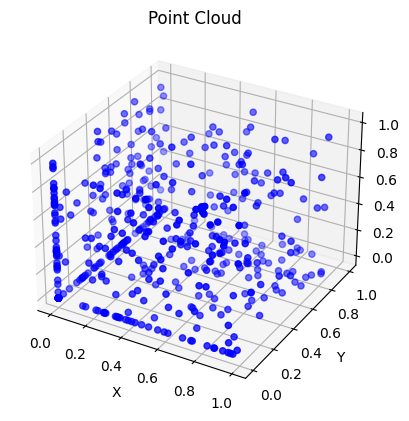

In [196]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_point_cloud(point_cloud, title='Point Cloud'):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], c='b', marker='o')
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

# Convert the PyTorch tensor to a NumPy array for visualization
reconstructed_point_cloud_np = outputs.squeeze().detach().cpu().numpy()

# Plot the reconstructed point cloud
plot_point_cloud(reconstructed_point_cloud_np.transpose(1, 0))


In [194]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_point_clouds(original_point_cloud, reconstructed_point_cloud, titles=('Original Point Cloud', 'Reconstructed Point Cloud')):
    fig = plt.figure(figsize=(12, 6))

    # Plot original point cloud
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(original_point_cloud[:, 0], original_point_cloud[:, 1], original_point_cloud[:, 2], c='b', marker='o')
    ax1.set_title(titles[0])
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')

    # Plot reconstructed point cloud
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(reconstructed_point_cloud[:, 0], reconstructed_point_cloud[:, 1], reconstructed_point_cloud[:, 2], c='r', marker='o')
    ax2.set_title(titles[1])
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')

    plt.tight_layout()
    plt.show()

# Assuming you have both original and reconstructed point clouds as NumPy arrays
# original_point_cloud_np and reconstructed_point_cloud_np

# Plot both point clouds
plot_point_clouds(original_point_cloud_np.transpose(1, 0), reconstructed_point_cloud_np.transpose(1, 0))


NameError: name 'original_point_cloud_np' is not defined

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to plot point clouds
def plot_point_cloud(point_cloud, title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], c='b', marker='o')
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

# Convert the output tensor to a NumPy array
reconstructed_point_cloud = outputs.squeeze().detach().numpy()

# Ensure the shape of the reconstructed point cloud is compatible with plotting
if reconstructed_point_cloud.shape[0] != 3:
    reconstructed_point_cloud = reconstructed_point_cloud.reshape(-1, 3)

# Plot original and reconstructed point clouds
plot_point_cloud(point_cloud_data, title='Original Point Cloud')
plot_point_cloud(reconstructed_point_cloud, title='Reconstructed Point Cloud')


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from plyfile import PlyData
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the PointNet Encoder
class PointNetEncoder(nn.Module):
    def __init__(self):
        super(PointNetEncoder, self).__init__()
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the PointNet Decoder
class PointNetDecoder(nn.Module):
    def __init__(self):
        super(PointNetDecoder, self).__init__()
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return x

# Define the PointNet Autoencoder
class PointNetAutoencoder(nn.Module):
    def __init__(self):
        super(PointNetAutoencoder, self).__init__()
        self.encoder = PointNetEncoder()
        self.decoder = PointNetDecoder()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Define the plot_point_clouds function
def plot_point_clouds(original_point_cloud, reconstructed_point_cloud, titles=('Original Point Cloud', 'Reconstructed Point Cloud')):
    fig = plt.figure(figsize=(12, 6))

    # Plot original point cloud
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(original_point_cloud[:, 0], original_point_cloud[:, 1], original_point_cloud[:, 2], c='b', marker='o')
    ax1.set_title(titles[0])
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')

    # Plot reconstructed point cloud
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(reconstructed_point_cloud[:, 0], reconstructed_point_cloud[:, 1], reconstructed_point_cloud[:, 2], c='r', marker='o')
    ax2.set_title(titles[1])
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')

    plt.tight_layout()
    plt.show()

# Load your own real-life point cloud data (replace this with your actual data loading)
def load_point_cloud_from_ply(file_path):
    ply_data = PlyData.read(file_path)
    x = ply_data['vertex']['x']
    y = ply_data['vertex']['y']
    z = ply_data['vertex']['z']
    points = np.column_stack((x, y, z)).astype(np.float32)
    return points

# Preprocess the loaded point cloud data
def preprocess_point_cloud(point_cloud_data):
    return resample_point_cloud(point_cloud_data, 1024)

# Resample point cloud to a fixed number of points
def resample_point_cloud(point_cloud, num_points):
    if len(point_cloud) == num_points:
        return point_cloud
    elif len(point_cloud) > num_points:
        indices = np.random.choice(len(point_cloud), size=num_points, replace=False)
        return point_cloud[indices]
    else:
        raise ValueError("Point cloud needs more points for resampling.")

# Define the file path to your point cloud data
point_cloud_file_path = "/content/new-simple-point-clouds/cube.ply"

# Load and preprocess your point cloud data
point_cloud_data = load_point_cloud_from_ply(point_cloud_file_path)
point_cloud_data = preprocess_point_cloud(point_cloud_data)

# Convert the NumPy array to a PyTorch tensor and transpose it
point_cloud_tensor = torch.tensor(point_cloud_data, dtype=torch.float32).unsqueeze(0).transpose(1, 2)

# Create an instance of the PointNet Autoencoder
model = PointNetAutoencoder()

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Define optimizer and loss function
criterion = nn.MSELoss()

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(point_cloud_tensor)


    # Reshape the output tensor to match the target tensor size
    # outputs = outputs.view(point_cloud_tensor.size(0), 3, -1)

    # Compute the reconstruction loss
    loss = criterion(outputs, point_cloud_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss every few epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')





In [ ]:
# Convert the output tensor to a NumPy array and reshape it
reconstructed_point_cloud_np = outputs.detach().numpy().squeeze().transpose(1, 2, 0)


# Plot both point clouds
plot_point_clouds(point_cloud_data, reconstructed_point_cloud_np)